<a href="https://colab.research.google.com/github/zinebzannouti/DL-CarClassificationWithFlask/blob/main/CNN_CASE_STUDY_SOLUTION/3_CNN_Model_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3-CNN-Model-Transfer Learning**

**1- Transfer Learning**

- Transfer learning models achieve optimal performance faster than the traditional ML models. It is because the models that leverage knowledge (features, weights, etc.) from previously trained models already understand the features. It makes it faster than training neural networks from scratc

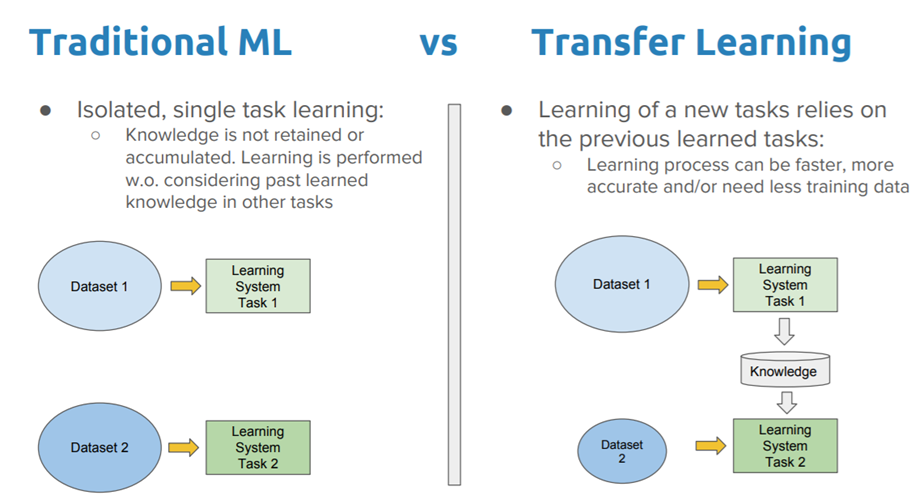

**Model Architechture** 

We describe our model as a set of a combination between
EfficientNet for compound scaling and MobileNet as
the model architecture. EfficientNet is a convolutional neural
network that relies on scaling the width, depth, and resolution uniformly. In addition to that, the network has a small
number of parameters compared to other models: it has only
12,320,535 parameters, but it has proven to reach better results
on the ImageNet dataset compared to other models with a
higher number of parameters. Thus, we transfer knowledge of
the trained EfficientNet model and use it in our system using
transfer learning. 

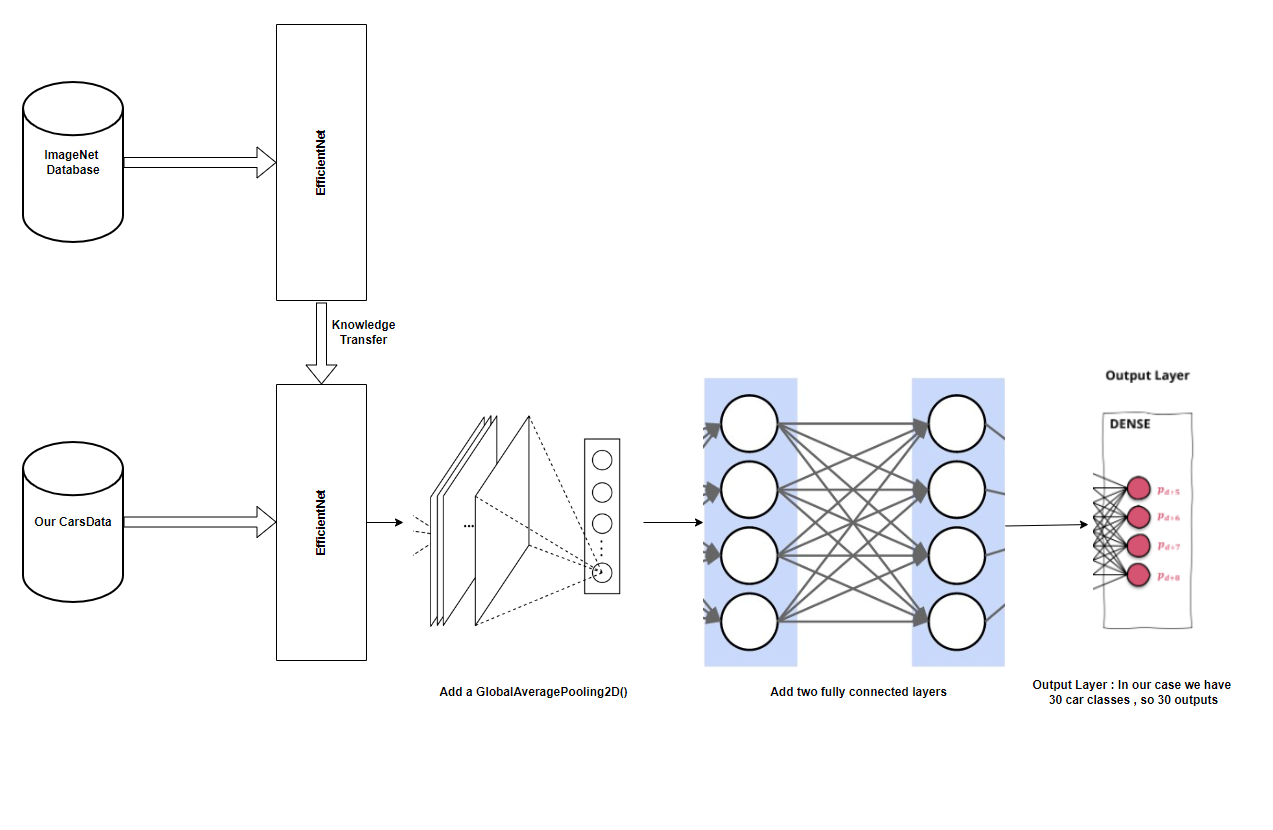

**EfficientNetB3 Architecture**

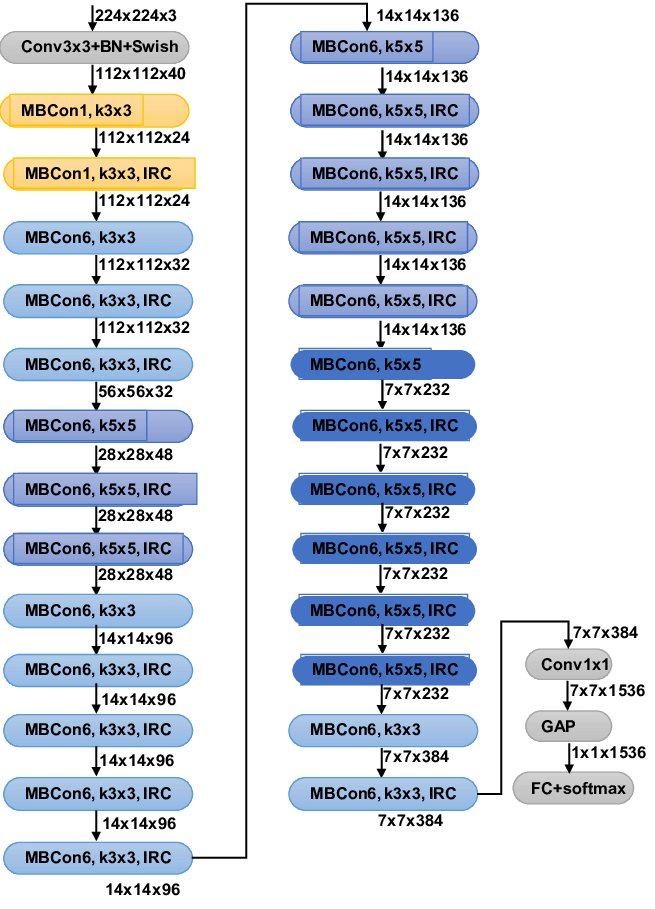

**Inverted Residual Block**

- An Inverted Residual Block, sometimes called an MBConv Block, is a type of residual block used for image models that uses an inverted structure for efficiency reasons. It was originally proposed for the MobileNetV2 CNN architecture. It has since been reused for several mobile-optimized CNNs.

- A traditional Residual Block has a wide -> narrow -> wide structure with the number of channels. The input has a high number of channels, which are compressed with a 1x1 convolution. The number of channels is then increased again with a 1x1 convolution so input and output can be added.

- In contrast, an Inverted Residual Block follows a narrow -> wide -> narrow approach, hence the inversion. We first widen with a 1x1 convolution, then use a 3x3 depthwise convolution (which greatly reduces the number of parameters), then we use a 1x1 convolution to reduce the number of channels so input and output can be added.

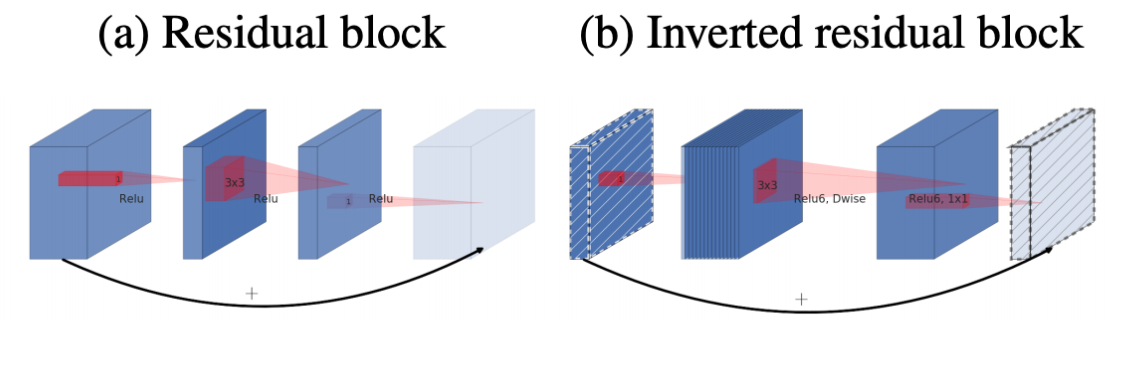

**Imports**

In [ ]:
!pip install -q keras
!pip install pyunpack
!pip install efficientnet

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization
from keras import optimizers
import efficientnet.keras as efn
from keras.preprocessing import image
from keras import backend as K
from keras.models import model_from_json
from keras.optimizers import Nadam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import keras
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import scipy.io as sio
import os

**Define The model**

Here we will take the EfficientNetB3 model pretrained on the imagenet dataset and we will transfer the learning to our new model by freezing the EfficientNetB3 model and creating a new model on top.

- **include_top**: Whether to include the fully-connected layer at the top of the network. Defaults to True.In our case we will set it to False since we are using transfer learning
- **weights**: One of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to 'imagenet'.

In [ ]:
#First instantiate a base model with pre-trained weights.
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False)

44107200/44107200 [==============================] - 2s 0us/step


In [ ]:
#Create a new model on top.
x = base_model.output

x = GlobalAveragePooling2D()(x) #ADD a GlobalAveragePooling2D layer
x = Dense(64, activation='relu')(x) #ADD Dense layer with the actication function relu
x = Dropout(0.4)(x) #ADD Dropout of 0.4
x = Dense(32, activation='relu')(x) #ADD Dense layer with the actication function relu
x = BatchNormalization()(x) #ADD BatchNormalization layer
predictions = Dense(30, activation='softmax')(x) #ADD Dense layer with the activation function softmax
model = Model(inputs=rebase.input, outputs=predictions)

**Compiling the model**

In [ ]:
model.compile(optimizer='adam',
loss='categorical_crossentropy', metrics=['accuracy'])

**Summary of the model**

In [ ]:
model.summary()

**Training The model**

- .fit_generator is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.

-  **generator**: a generator whose output must be a list of the form:
                      - (inputs, targets)    
                      - (input, targets, sample_weights)
a single output of the generator makes a single batch and hence all arrays in the list 
must be having the length equal to the size of the batch. The generator is expected 
to loop over its data infinite no. of times, it should never return or exit.

- **steps_per_epoch :** it specifies the total number of steps taken from the generator
 as soon as one epoch is finished and next epoch has started. We can calculate the value
of steps_per_epoch as the total number of samples in your dataset divided by the batch size.

- **Epochs :** an integer and number of epochs we want to train our model for.

- **Verbose :** specifies verbosity mode(0 = silent, 1= progress bar, 2 = one line per epoch).


- **validation_data**can be either:
                      - an inputs and targets list
                      - a generator
                      - an inputs, targets, and sample_weights list which can be used to evaluate
                        the loss and metrics for any model after any epoch has ended.

- **validation_steps**:only if the validation_data is a generator then only this argument
can be used. It specifies the total number of steps taken from the generator before it is 
stopped at every epoch and its value is calculated as the total number of validation data points
in your dataset divided by the validation batch size.

In [ ]:
batch_size = 32
input_shape = (240,240)
train_dir = '/content/drive/MyDrive/CarsDataSplit/train'
test_dir = '/content/drive/MyDrive/CarsDataSplit/val'

In [ ]:
#Define train and test datagen with ImageDataGenerator
train_datagen = ImageDataGenerator(
    #ADD_RESCALE
    rescale = 1./255,
    #ADD_SHEAR_RANGE of 0.2
    shear_range = 0.2,
    #ADD ROTATION RANGE OF 20°
    rotation_range = 20,
    #ADD width shift range OF 0.1
    width_shift_range = 0.1,
    #ADD height shift range OF 0.1
    height_shift_range = 0.1, 
    #ADD zoom range between 0.9 and 1.25
    zoom_range = [0.9, 1.25],
    #ADD brightness range BETWEEN 0.5 AND 1.5
    brightness_range = [0.5, 1.5],
    #ADD horizontal flip
    horizontal_flip = True
    )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Define train and test generator
train_generator = train_datagen.flow_from_directory(
    #TODO
    #ADD the train_dir,
    '/content/drive/MyDrive/CarsDataSplit/train',
    #ADD the class_mode
    class_mode = 'categorical',
    #ADD the target_size as input_shape
    target_size = input_shape,
    #ADD batch_size as batch_size
    batch_size = batch_size
    )

validation_generator = test_datagen.flow_from_directory(
    #TODO
    #ADD the test_dir
    '/content/drive/MyDrive/CarsDataSplit/val',
    #ADD the class_mode
    class_mode = 'categorical',
    #ADD the target_size as input_shape
    target_size = input_shape,
    #ADD batch_size as batch_size
    batch_size = batch_size
    )

Found 2283 images belonging to 30 classes.
Found 587 images belonging to 30 classes.


In [ ]:
#TODO
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size + 1, 
                    validation_data = validation_generator, 
                    validation_steps = validation_generator.samples // batch_size + 1,
                    epochs = 20,
                    verbose = 1)
                    #ADD train_generator
                        #steps_per_epoch to be equal to train_generator.samples//batch_size + 1 ,
                        # ADD validation_data
                        #ADD validation_steps to be equal to validation_generator.samples // batch_size + 1,
                        #ADD 20 epochs
                        #ADD verbose equal 1)

**Try to Plot the Accuracy and the loss graphs**

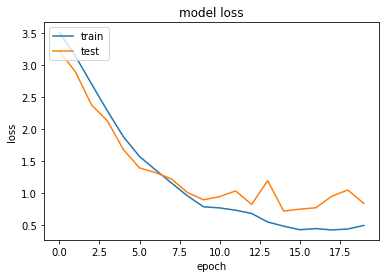

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

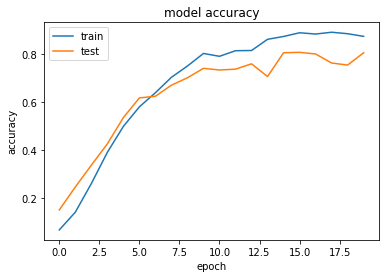

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show() 